# Classifying skin lesions using a convolutional neural network

The goal of this assignment is to design and implement a deep learning model
able to determine the category of a skin lesion from a dermoscopic image.

This is a _multiclass classification_ problem where the inputs are RGB
images; therefore, the most natural approach is to use a Convolutional Neural
Network (CNN) for classification.

In this document I will go through the different steps of the data analysis
pipeline, explaining the reasons behind the choices I made and their
consequences on the results of the experiments.

#### Summary

This report is organized as follows:  

1. [**Data exploration**](#Data-exploration)
1. [**(brief) Literature review**](#Literature-review)
1. [**Experiment design**](#Experiment-design)
1. [**Implementation details**](#Implementation-details)
1. [**Results**](#Results)
1. [**Conclusions**](#Conclusions)

## Data exploration
[back to top](#Summary)

#### Imports

In [1]:
%matplotlib inline

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import pandas as pd

In [4]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn

In [5]:
import os
import sys

In [6]:
import numpy as np

In [7]:
import torchvision.transforms as transforms
import PIL

In [8]:
from tqdm import tqdm

In [9]:
# Add parent folder to system path to allow loading modules
sys.path.append("..")

Set up folders

In [10]:
DATA_FOLDER = "../data"
ANNOTATION_FILE_NAME = "HAM10000_metadata.csv"
LABEL_COLUMN = 'dx'

### Read annotations

In [11]:
annotation_df = pd.read_csv(os.path.join(DATA_FOLDER, ANNOTATION_FILE_NAME))

In [12]:
annotation_df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

## Data exploration
[back to top](#Summary)

The very first step in most data analysis pipelines consists in
_looking at the dataset_ and trying to understand its characteristics, in order
to make the appropriate decisions when designing the experiments.

The following table and plot show the number of samples present in the dataset for each
class.

In [13]:
annotation_df.groupby(LABEL_COLUMN)['lesion_id'].describe()[['count']]

,count
dx,
akiec,327
bcc,514
bkl,1099
df,115
mel,1113
nv,6705
vasc,142


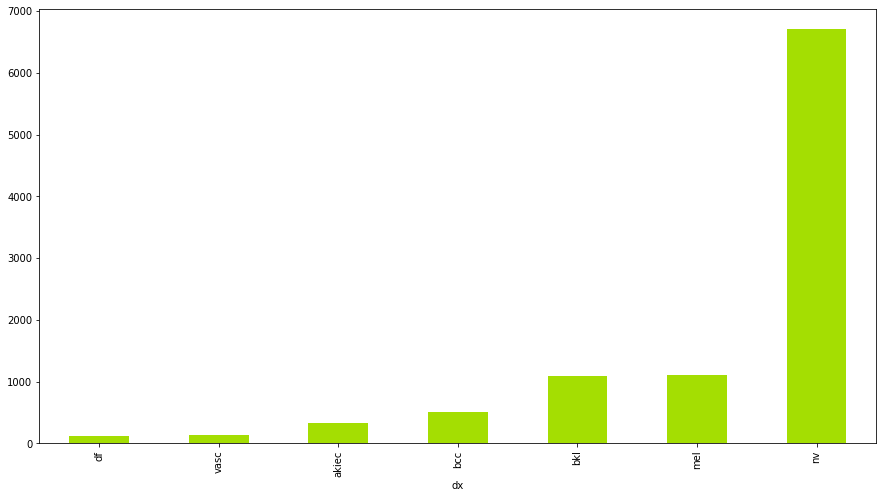

In [14]:
plt.figure(figsize=(15,8))
annotation_df.groupby(LABEL_COLUMN).count()['sex'].sort_values().plot(kind='bar', color='#a4de02')

This plot clearly shows that the dataset is *heavily inbalanced*: the most
represented class is by far **nv**, corresponding to *benign melanocytic nevi*, with
6660 samples, while the least represented class, **df** (*dermatofibromas*), has
only 115 samples in this dataset.


This was to be expected, since medical datasets often contain many more samples
of a given feature (in this case, skin lesions) *not* affected by a disease than
samples presenting signs of a medical condition.


Apart from the evident class inbalance, some of the classes (most of them,
actually) have a very small number of samples in absolute terms, which may lead
to severe problems in the training process, unless properly addressed.


Finally, a consideration on the goal of the task itself: normally the
performance of a model trained to solve a classification task is evaluated based
on its *accuracy*, that is the percentage of samples from a *test set* (that is
a set which hasn't been used **in any way** during the training) which is
correctly classified by the model.
This is fine for most cases (and as a matter of fact it is one of the metrics
used in this analysis), however it is important to take into account the nature
of this problem, and in particular what the consequences of an error would be, when commenting results.
The samples present in the set can be grouped in **two** categories: lesions
that are **malignant** (or eventually might develop into malignant ones), and
those which are **benign**. With that in mind, it is clear that
**type II errors** (false negatives, that is classifying a malignant lesion as a
benign one) should be minimized, at the cost of increasing the occurrence of
**type I errors** (false positives), since the consequences would be very different
for the two types of mistakes.

These are crucial aspects of this particular dataset, which need to be
taken into consideration when choosing the parameters for the training process
(hyperparameters and overall training strategy). All of the choices made to
address the issues discussed above are explained in detail in section
[experiment design](#Experiment-design).

### Visualize sample images

Since the input are RGB images, visualizing a few of them for each class might
provide some useful insight.

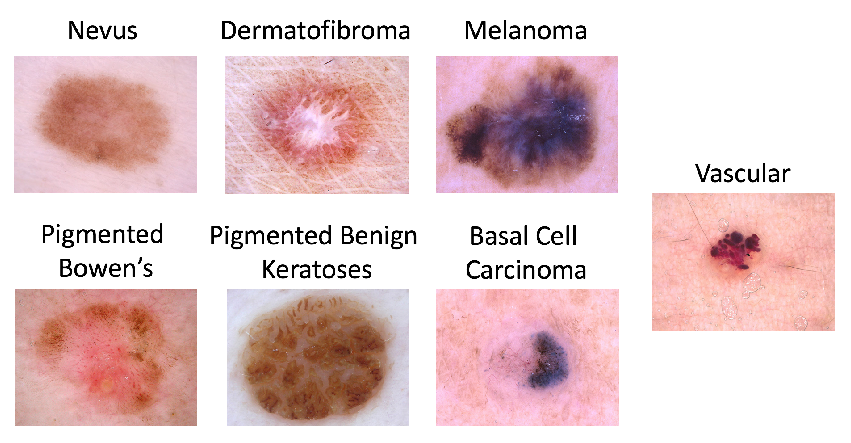

In [15]:
sample_image = plt.imread("../lesions.png")
plt.figure(figsize=(15,8))
plt.axis('off')
plt.imshow(sample_image);

Display a few images from the dataset on a grid in order to visually check their characteristics

In [16]:
from lib.dataset import HAM10000, create_train_val_split, read_meta_data

In [17]:
train_ids, val_ids = create_train_val_split(DATA_FOLDER, 0.8, 0.2)

In [18]:
# Order so that classes that get confused are shown close to one another
class_labels = ['akiec', 'bkl', 'bcc', 'df', 'mel', 'nv', 'vasc']

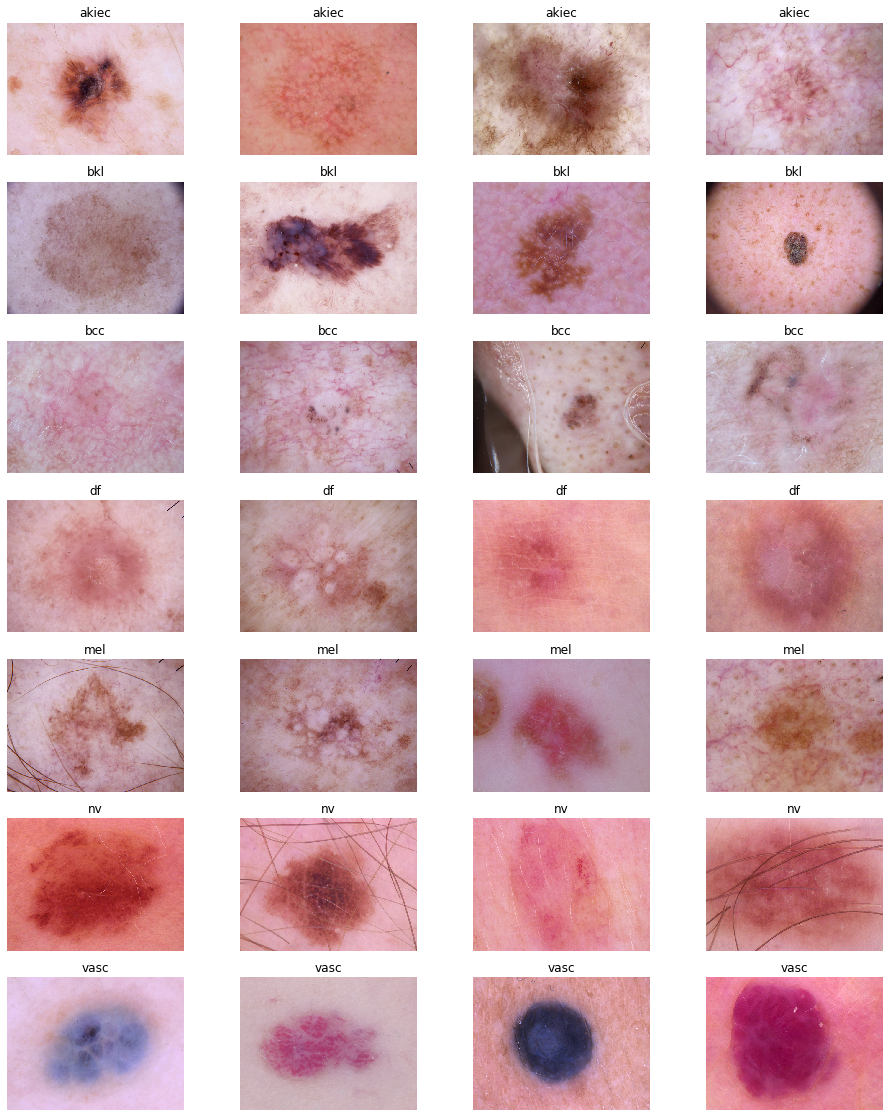

In [19]:
n_rows = len(class_labels)
n_cols = 4

f, axes = plt.subplots(n_rows, n_cols, figsize=(16, 20))

for x, l in enumerate(class_labels):
    samples4 = annotation_df[(annotation_df['dx'] == l)].sample(frac=1.0, random_state=9876).iloc[:4]
    for y, im_id in enumerate(samples4['image_id']):
        img = plt.imread(os.path.join(DATA_FOLDER, "{}.jpg".format(im_id)))
        axes[x, y].axis('off')
        axes[x, y].imshow(img)
        axes[x, y].set_title(l)

While I'm not a physician myself, I can make a few general considerations on
some characteristics of the images in this dataset:

* Some of the lesions categories such as *vascular lesions* (class label
  **vasc**) are (somewhat) easily distinguishable from the others because of
  their color or texture, whereas others seem to be less easy to tell apart (for
  instance *dermatofibromas* (**df**) and *melanomas* (**mel**). Therefore, it is
  reasonable to expect that samples belonging to one of these two classes might be mixed up more easily.

* The color of the lesion seems to be somewhat important in determining the
  class of the lesion; this should be taken into consideration when applying any
  kind of transformation to the color space of the images.
  
* Samples from different categories seem to present differences mainly in terms of *texture pattern*, which are relatively low-level features (as opposed to differences in categories in "traditional" classification problems, where objects from different classes, e.g. *car* and *motorcycle* are distinguishable because of higher level features). In convolutional neural networks, there is a relationship between the *complexity* of a feature and the *depth* of a layer: early layers of the network detect simple, low-level features such as *edges* and *blobs*, whereas layers deeper in the network detect more complex features such as elements which compose a complex object such as a person's face or a specific type of object. While I'm not exploring this aspect in this report, if I had to bet I would say that the most important features for this specific classification task are **mid-level features** such as *texture*, which correspond to filters of layers at a **medium depth** in the network.

## Literature review
[back to top](#Summary)

I searched on Google the terms `skin lesions classification convolutional neural network` and went through a couple of those.

Unsurprisingly, most of them were more or less similar to each other, the main differences being the network architecture (**Alexnet**, **Resnet{50,101,152}**, some variant of the **Inception network**...), the datasets used and the type of task they were trying to solve (some of them tried to discriminate between several categories of skin lesions whereas others tried to solve the binary classification task malignant/non-malignant).

I focused on one in particular, available at https://arxiv.org/pdf/1812.02316.pdf, since I found it to be very well written, plus the task the authors performed (multiclass classification) was similar to the one of this assignment and the overall approach very akin to what I would have done if I had to start from scratch.

In this paper the authors describe the results they obtained by training a CNN on a dataset obtained by merging three different datasets, for a total of 5286 images of varying quality divided in **twelve** categories.
They used a **ResNet152** architecture (replacing the last layer with one having 12 outputs) with the pre-trained weights trained on the ImageNet database, using data augmentation techniques to compensate for the lack of data.

They indicate all the hyperparameters they used to train their network, which I used as a starting point for my experiments, due to the similarities of the tasks.

The main metric they rely on to assess their model's performance is the **Area Under Curve** (AUC), that is the area under the ROC curve (https://it.wikipedia.org/wiki/Receiver_operating_characteristic), for each one of the twelve classes individually.

They report excellent results (AUC $\ge$ 0.90) for all of the twelve categories (except for the *wart* class, which had a slightly lower AUC score of 0.89).

## Experiment design
[back to top](#Summary)

In this section I will describe the different choices I made in designing the experiments.

### Training/validation split

The dataset was split in *training* and *validation* set based on the following considerations:

* The ratio of samples from each classes should be the same in both sets.
* Have enough samples for all categories (especially for the least represented ones) in the validation set, so that metrics on that set are stable enough to provide useful insight about how the training is proceeding.

The size of the validation set was chosen according to these points. 20% of all available samples ended up in the validation set, the remaining 80% in the training set.

Given the very limited amount of samples for some of the classes, I chose *not* to keep data aside for a *test set*, as I felt there wouldn't have been enough samples for some of the classes to provide a reliable estimate of the model's performance.

Instead, the network's performance will be evaluated considering (for each metric) the values computed on the validation set in the final epochs of training, knowing that this estimate will be *biased*, as the choice of hyperparameters will be guided by the algorithm's performances on _that_ set.

The auxiliary function used to produce the training/validation splits takes a seed for the random number generator as input, to guarantee the reproducibility of the experiment.

In [20]:
# Get training ids and validation ids
train_ids, val_ids = create_train_val_split(DATA_FOLDER, 0.8, 0.2, random_state=123)

In [21]:
print("Samples in training set: {}".format(len(train_ids)))
print("Samples in validation set: {}".format(len(val_ids)))

n_samples_total = len(val_ids) + len(train_ids)

print("Total samples: {}".format(n_samples_total))

# Sanity checks: union must be equal to total, intersection must be 0
assert (len(set(val_ids).union(set(train_ids))) == n_samples_total)
assert (len(set(val_ids).intersection(set(train_ids))) == 0)

Samples in training set: 8010
Samples in validation set: 2005
Total samples: 10015


In [22]:
data_df = read_meta_data(DATA_FOLDER)

data_train = data_df.loc[train_ids]
data_val = data_df.loc[val_ids]

#### Number of samples for each class in the validation set

In [23]:
data_val.groupby(LABEL_COLUMN)['lesion_id'].describe()[['count']]

,count
dx,
akiec,66
bcc,103
bkl,220
df,23
mel,223
nv,1341
vasc,29


#### Number of samples for each class in the training set

In [24]:
data_train.groupby(LABEL_COLUMN)['lesion_id'].describe()[['count']]

,count
dx,
akiec,261
bcc,411
bkl,879
df,92
mel,890
nv,5364
vasc,113


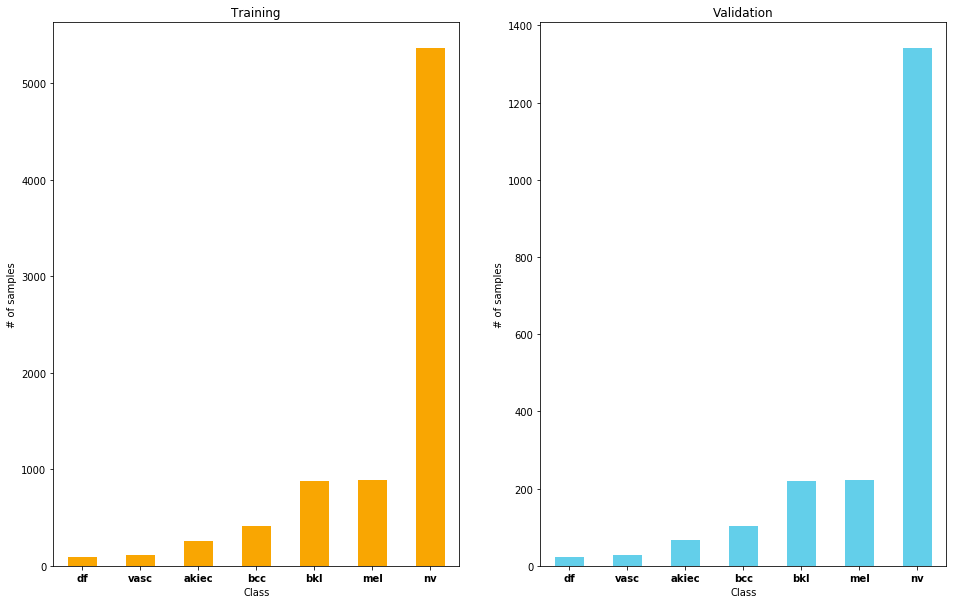

In [25]:
f, axes = plt.subplots(1, 2, figsize=(16, 10))

chart_train = data_train.groupby(LABEL_COLUMN).count()['sex'].sort_values().plot(title="Training", kind='bar', color="#f9a602", ax=axes[0])
chart_train.set_xticklabels(chart_train.get_xticklabels(), rotation=0, fontweight='bold')

chart_val = data_val.groupby(LABEL_COLUMN).count()['sex'].sort_values().plot(title="Validation", kind='bar', color='#63CFEA', ax=axes[1])
chart_val.set_xticklabels(chart_val.get_xticklabels(), rotation=0, fontweight='bold')

matplotlib.rcParams.update({'font.size': 14})


axes[0].set_xlabel("Class")
axes[1].set_xlabel("Class")

axes[0].set_ylabel("# of samples")
axes[1].set_ylabel("# of samples");

### Sampling strategy for training

In [26]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import WeightedRandomSampler

To tackle the issue of class imbalance, samples from the training set are sampled in a way such that in every batch (I use the term "batch" here in a broader sense) there is roughly the same amount of data points for each one of the seven classes.

From the implementation point of view, this is achieved by passing to the *DataLoader* an instance of class [`torch.utils.data.WeightedRandomSampler`](https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler) (warning: the example provided in the documentation is counterintuitive), which samples from the availables elements of a set (in this case, the training set) given some predefined weights.

Each sample belonging to class $c$ is assigned a weight corresponding to $\frac{1}{f_c}$, where $f_c$ is the ratio of samples belonging to class $c$ in the training set. 

This is equivalent to duplicate samples from less represented classes until each class has the same amount of samples.

Because of this, I considered an epoch consisting of a fixed number of samples ($50 \times 7 \times \texttt{BATCH_SIZE}$), following the logic that for each epoch the training algorithm should "see" enough samples of each class.

The following code shows an example of several batches of data being created using that sampler.

In [27]:
dataset_train = HAM10000(DATA_FOLDER, train_ids)

weights = dataset_train.make_weights_for_balanced_classes()

sampler = WeightedRandomSampler(weights, len(weights))

In [29]:
dataloader_train = DataLoader(dataset_train, 8, sampler=sampler, num_workers=4)

i = 0

# Initialize list for keeping track of counts
counts = [0] * 7

SAMPLE_ITERATIONS = len(dataloader_train) // 8

for data, target in dataloader_train:
    
    for c in target:
        counts[c] += 1
    
    i += 1

In [30]:
for i, c in enumerate(dataset_train.get_class_map_dict()):
    print("# of samples for class {}:\t{}".format(c, counts[i]))

# of samples for class akiec:	1178
# of samples for class bcc:	1115
# of samples for class bkl:	1142
# of samples for class df:	1155
# of samples for class mel:	1088
# of samples for class nv:	1169
# of samples for class vasc:	1163


### Weighted loss

Despite the use of the weighted sampler to correct the class imbalance, there still is a tangible difference for what it concerns the amount of *information* (in a broad sense) available for each category, since the samples were simply replicated and thus did not bring any amount of additional information for the least represented classes.

To further compensate for this, and also to weight differently errors made when mislabeling samples representing malignant lesions, as already discussed in the [**Data exploration**](#Data-exploration) Section, the loss function used ([`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss)) is passed the optional `weight` parameter, consisting of a vector representing weights for each of the classes.

The following values were chosen, taking into consideration both the (estimated) importance of the lesion and the amount of samples available for training:

| Class| Weight |
|:-------------|-----:|
| `akiec` | 2.5 |
| `bcc` | 2.5 |
| `bkl` | 2.5 |
| `df` | 2.5 |
| `mel` | 2.0 |
| `nv` | 1.0 |
| `vasc` | 2.0 |

### Data augmentation

Another tool used to compensate for the lack of variability for some of the classes, and thus reduce overfitting, was *data augmentation*: images passed to the training algorithm were processed using classes from the [`torchvision.transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision-transforms) module, which allow to apply different kinds of transformations to the image.

The following transformations were applied in sequence, all with probability 0.5:

* Color jitter
* Horizontal and vertical flip
* Random crop followed by resize to original size
* Random rotation 

A parameter passed to the main training script can control which of these transformations are applied.

The transformations were applied exclusively when passing images for training (images for validation were left untouched).

The following code shows an example of several versions of the same image obtained with the data augmentation pipeline just described.

In [32]:
from main import get_data_augmentation_transforms

/home/matteo/miniconda3/envs/lesions-classification/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/matteo/miniconda3/envs/lesions-classification/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/matteo/miniconda3/envs/lesions-classification/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([

In [33]:
da_transforms = get_data_augmentation_transforms(4)

# Add ToPilImage for plotting
da_transforms = transforms.Compose([da_transforms, transforms.ToPILImage()]) 

In [34]:
dataset_train_augmented = HAM10000(DATA_FOLDER, train_ids, da_transforms)

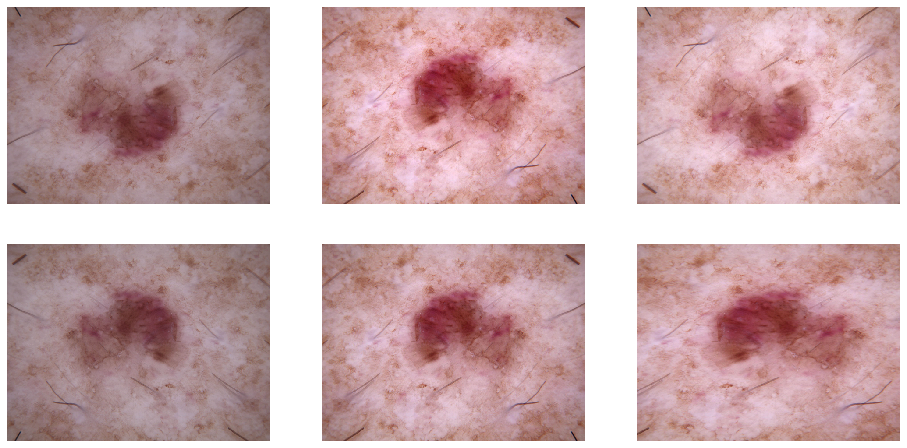

In [35]:
# Creates two subplots and unpacks the output array immediately
n_rows = 2
n_cols = 3
f, axes = plt.subplots(n_rows, n_cols, figsize=(16,8))
for ii in range(n_rows * n_cols):
    x = ii // n_cols
    y = ii % n_cols
    img, _ = dataset_train_augmented[0]
    axes[x, y].imshow(img)
    axes[x, y].grid(False)
    axes[x, y].axis('off')
    

### Network architecture

In order to limit the amount of time required for training the network, I opted for the `resnet50` architecture (as opposed to the `resnet152` used in the article mentioned in the [Literature review](#Literature-review) Section).

I estimated that the potential loss in terms of accuracy should be limited, considering that the complexity of the `resnet50` architecture should be more than enough for this task.

The only modification to the network was the substitution of the very last layer (which originally has 1000 nodes, for the ImageNet classification task) with one which has 7 nodes, one for each of the classes present in this dataset following the instructions from [the official pytorch documentation](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#resnet).

#### Transfer learning

In order to speed up the training process I initialized the network's weights with the ones trained on the Imagenet dataset (apart of course those in the very last layer, which was replaced), passing the flag `pretrained=True` to the function creating the network object in the Python script.

However I chose **not** to freeze any layer of the network, because of the point discussed in the last part of the [Data exploration](#Data-exploration) Section.

### Monitoring experiments

I used Tensorboard to monitor the experiments, creating summaries for different metrics, due to its ease of use and the possibility to monitor experiments in real time.
Each run was tagged so that it was possible to filter the plots using the Tensorboard web interface and compare different runs.

The **loss** curve computed for both the training and the validation set was of course the main metric used to assess the overall "quality" of the run, along with the **classification accuracy**.

Moreover, for every class (1 vs all) the following metrics are computed and logged:

* **Precision**
* **Recall**
* **ROC AUC**

In addition to this, at the end of every epoch the **confusion matrix** computed on the validation set (and every 10 epochs also on the training set) was printed on the console, to have a detailed view of how the model is performing for each category individually (given the heavy imbalance of the dataset, the accuracy alone is not enough).

### Scheduling experiments

I kept track of planned, running and completed experiments (and their configuration), using a spreadsheet on Google Drive:

![title](./experiments_scheduling_screenshot.png)

(\*right click and "Open image in new tab" for a larger, more readable version)

A bash script was created for each one of the runs, calling the main Python script `main.py` with different parameters.

Experiments were queued up either explicitly with `&&` or using the `at` scheduler.

Considering the large number of potential hyperparameters to consider, I chose to focus only on the ones that seemed to influence the most, in particular the choice of the **learning rate** (**LR**), along with **learning rate decay** and the **weight decay**.

An exploratory run where the value of the learning rate started from a very small one and increased esponentially over time (following the idea suggested in [this](https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0) article) was used to estimate the viable range for that hypermarameter.

Inputs were normalized channel-wise by subtracting the mean and dividing by the standard deviation (these values were precomputed from samples in the training set).
Normalization was applied to both training and validation samples (for very obvious reasons), using the same mean and standard deviation values.

The batch size was chosen based on the maximum amount of data that could fit into GPU memory for a given architecture (**8** for `resnet50` and `resnet101`, **6** for `resnet152`).

Almost all other parameters were kept fixed as they seemed to have very little or no effect at all on the results.

More details on how the different configurations performed in the [Results](#Results) Section.

## Implementation details
[back to top](#Summary)

The code provided was massively reorganized and extended to facilitate the implementation of several different configurations.

#### `main.py`

The `parse_args` function in the `main.py` script collects all parameters which can be passed to it and serves as a documentation of sort for the script itself.

The options range from network architecture to the various hyperparameters such as learning rate and weight decay.

It is in particular possible to control which transforms (if any at all) are used to augment the dataset, via the option `--data-augmentation-level`. Details on this in the [Data augmentation](#Data-augmentation) Subsection.

Functions `main`, `test` and `train` have been extended to include the code necessary to log several metrics in the form of Tensorboard events, so that experiments can be monitored in real time using Tensorboard, as explained in the previous Section.

The script also prints useful information about the current run at the end of each epoch, such as the ETA of the experiment conclusion, which helps for scheduling experiments, and the confusion matrix for the validation and training set, as specified in the previous Section.

A sample bash script `train_command.sh` where parameters are set is provided as a reference; a new one was created for every configuration taking that script as starting point.

#### `lib/dataset.py`

A new method `make_weights_for_balanced_classes` for class `HAM10000` was added to generate weights for the sampler, which simply returns the inverse ratio of samples for each class.

Moreover, the class' method `get_item` was modified to include the use of *transforms* to generate augmented images (when specified).

#### `lib/utils.py`

Several new functions were added to this module:

* `plot_tf_log`: used for this report to plot curves from metrics coming from exported Tensorboard csv files.
* `produce_per_class_stats`: as the name suggests, produces stats (precision, recall, etc.) for each one of the seven categories in the dataset.
* `cm2df`: returns a dataframe which is used to display the confusion matrix in a way that it includes the categories' names as rows and columns headers.

#### `constants.py`

A simple Python module containing some constant values, much like a C/C++ header file would do. Currently it is used exclusively to store the status message format string and parameters for images normalization (per channel mean and standard deviation, previously computed on the training set).

## Results
[back to top](#Summary)

### Best model hypermarameters/configuration

Here is the configuration of the model that achieved the best results:

 * Network architecture: **resnet50**
 * Use pretrained weights: **YES** (trained on Imagenet)
 * Freeze layers: **NO**
 * Normalize input: **YES**
 * Optimizer: `Adam` with default values for parameters $\beta_1$ and $\beta_2$ ($0.9$ and $0.999$ respectively)
 * Initial learning rate: $\mathbf{10^{-5}}$
 * Data augmentation level: $\mathbf{3}$ (horizontal/vertical flips, random crops, color jitter)
 * Batch size: $\mathbf{8}$
 * Number of epochs trained: $\mathbf{300}$ (although performances plateaued after roughly $150$)

### Plots

Here are the plots of loss and accuracy for both training and validation set.

In [36]:
BEST_EXPERIMENT_NAME = "run-Oct06_16-32-15_gipsy-dangerrun22_LRscheduleresnet50_pretrained_Adam_0.00001_DA3_normalize_input_weighted_loss"

In [37]:
custom_palette = ['#f9a602', '#63CFEA']  # train, val

In [38]:
from lib.utils import plot_tf_log, cm2df

../lib/utils.py:216: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


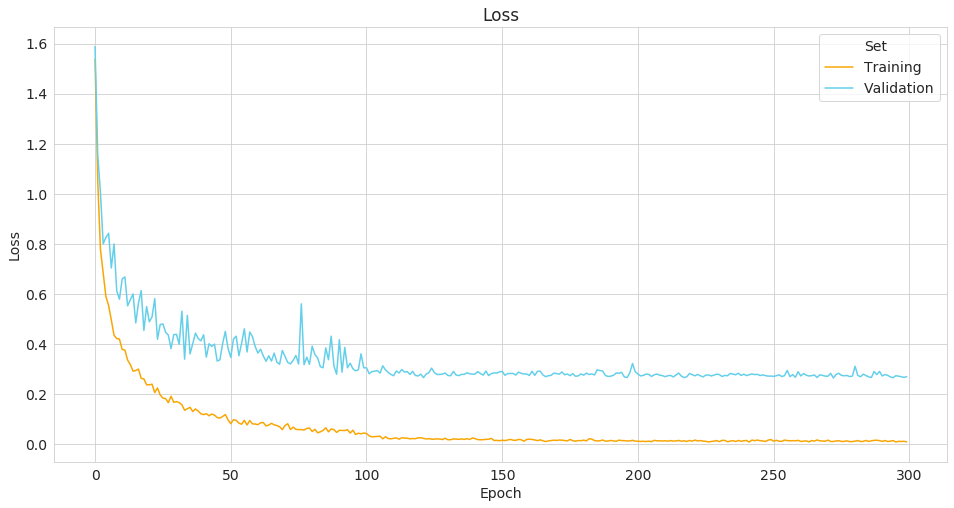

In [39]:
plt.figure(figsize=(16,8))

curves_tags = ["_Loss_train-tag-Loss", "_Loss_val-tag-Loss"]

csv_files_loss = list()
for ct in curves_tags:
    csv_files_loss.append(os.path.join("..", "results", "{}{}.csv".format(BEST_EXPERIMENT_NAME, ct)))

plot_tf_log(csv_files_loss, "Loss", y_label="Loss", palette=custom_palette)

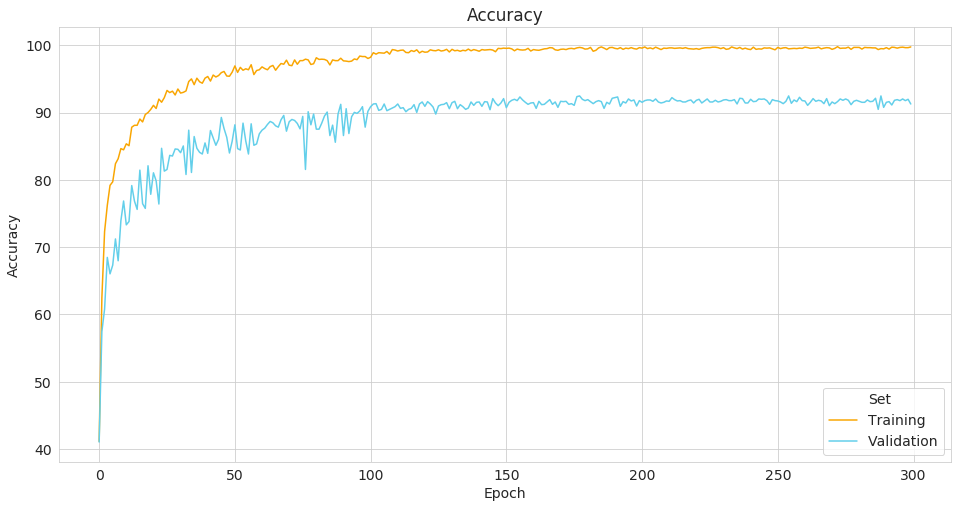

In [40]:
plt.figure(figsize=(16,8))

curves_tags = ["_Accuracy_train-tag-Accuracy", "_Accuracy_val-tag-Accuracy"]

csv_files_loss = list()
for ct in curves_tags:
    csv_files_loss.append(os.path.join("..", "results", "{}{}.csv".format(BEST_EXPERIMENT_NAME, ct)))

plot_tf_log(csv_files_loss, "Accuracy", y_label="Accuracy", palette=custom_palette)

While there is still a bit of overfit, as the training loss goes essentially to zero from around epoch 150, this does not seem to impact negatively on the model's performance on the validation set, which reaches a plateau but does not get worse.

The learning rate was decreased by a factor of 10 after epochs 100 and 200, this however didn't seem to have a particular effect in decreasing the loss (the initial learning rate was probably a good value already), however it might have helped in reducing the oscillations of the accuracy and loss values (this is particularly visible after the first dip after epoch 100).

The following plot shows how not using any kind of data augmentation impacts negatively on the training, by having the training loss going much quicker to zero and therefore preventing the model to generalize enough to achieve better performances on the validation set.

The two lines tagget `DA3` are the same ones as before, the other two tagged `DA0` refer to results obtained with the same configuration as the previous one but **without** data augmentation (achieved by passing option `--data-augmentation level 0` to the main script).

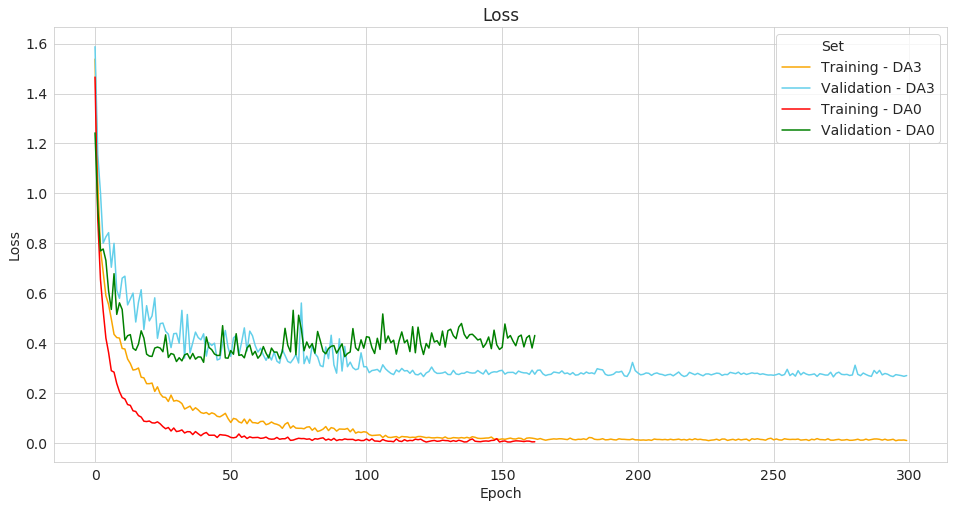

In [41]:
plt.figure(figsize=(16,8))

EXP_NAME_NO_DA = "run21_nodaresnet50_pretrained_Adam_0.00001_DA0_normalize_input_weighted_loss"
EXP_NAME_NO_DA = "run-Oct06_12-31-25_gipsy-dangerrun21_nodaresnet50_pretrained_Adam_0.00001_DA0_normalize_input_weighted_loss"

csv_files_loss = list()

curves_tags = ["_Loss_train-tag-Loss", "_Loss_val-tag-Loss"]

for ct in curves_tags:
    csv_files_loss.append(os.path.join("..", "results", "{}{}.csv".format(BEST_EXPERIMENT_NAME, ct)))
    
for ct in curves_tags:
    csv_files_loss.append(os.path.join("..", "results", "{}{}.csv".format(EXP_NAME_NO_DA, ct)))

set_names = [
    "Training - DA3",
    "Validation - DA3",
    "Training - DA0",
    "Validation - DA0",
]
    
plot_tf_log(csv_files_loss, "Loss", set_names=set_names, y_label="Loss", palette=custom_palette + ['red', 'green'])

Here are the values for the accuracy computed on the validation set in the last 50 epochs of training:

In [42]:
acc_val_df = pd.read_csv(os.path.join(
    "..", "results", "{}{}.csv".format(
        BEST_EXPERIMENT_NAME, "_Accuracy_val-tag-Accuracy")))
acc_val_df.iloc[-50:].describe()['Value']

count    50.000000
mean     91.660848
std       0.383166
min      90.473816
25%      91.521194
50%      91.670822
75%      91.857855
max      92.468826
Name: Value, dtype: float64

### Per-class performances

The following is the confusion matrix reporting the results obtained on the validation set in the very last epoch:

**Important**: since this has be obtained using `scikit-learn`'s `confusion_matrix` function, true labels are on rows, predicted labels are on columns (see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix for more information).

In [43]:
cm_test = np.load("../results/confusion_matrix_test_latest.npy")
cm_test_pretty = cm2df(cm_test, dataset_train.class_map_dict)
cm_test_pretty

,akiec,bcc,bkl,df,mel,nv,vasc
akiec,53,1,5,0,2,5,0
bcc,3,91,4,1,1,3,0
bkl,7,0,193,0,11,9,0
df,0,0,0,17,1,5,0
mel,1,0,16,0,177,29,0
nv,1,4,19,0,42,1274,1
vasc,0,0,1,0,0,3,25


In [44]:
for i, c in enumerate(dataset_train.class_map_dict):
    P = sum(cm_test[i, :])
    TP = cm_test[i, i]
    FN = P - TP
    FP = sum(cm_test[:, i]) - TP
    
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    
    # Compute ratio of hard mistakes, that is how many samples are mistaken for benign lesions
    if i == 5:
        hard_mistakes = 0.0
    else:
        hard_mistakes = cm_test[i, 5]/P
    
    # Align strings manually to improve readability
    if hard_mistakes < 0.1:
        hm_str = " {:.2f} %".format(hard_mistakes*100)
    else:
        hm_str = "{:.2f} %".format(hard_mistakes*100)
    
    print("Class {}\t: precision = {:.3f}, recall = {:.3f}. \"Hard mistakes\" percentage: {}".format(
        c, precision, recall, hm_str))

Class akiec	: precision = 0.815, recall = 0.803. "Hard mistakes" percentage:  7.58 %
Class bcc	: precision = 0.948, recall = 0.883. "Hard mistakes" percentage:  2.91 %
Class bkl	: precision = 0.811, recall = 0.877. "Hard mistakes" percentage:  4.09 %
Class df	: precision = 0.944, recall = 0.739. "Hard mistakes" percentage: 21.74 %
Class mel	: precision = 0.756, recall = 0.794. "Hard mistakes" percentage: 13.00 %
Class nv	: precision = 0.959, recall = 0.950. "Hard mistakes" percentage:  0.00 %
Class vasc	: precision = 0.962, recall = 0.862. "Hard mistakes" percentage: 10.34 %


The worse results are obtained with for class `mel` (melanomas), both because precision and recall values are low with respect to other classes (class `df` has a lower falue for recall, but the reliability of this score is quite limited due to the very little amount of samples belonging to this class in the validation set), and especially because 13 % of the samples (29/223) are misclassified as benign lesions

This might be addressed by further increasing the weigth in the loss function associated with that class, even if it might negatively influence the performance of the `nv`. However in that case there is a risk of negatively influencing the performances on other classes apart from `nv`, which of course should be avoided.

The following plot shows instead how balanced accuracy, that is a measure that takes into account class frequency and weights more classification errors of samples less represented in the dataset, evolved over time.

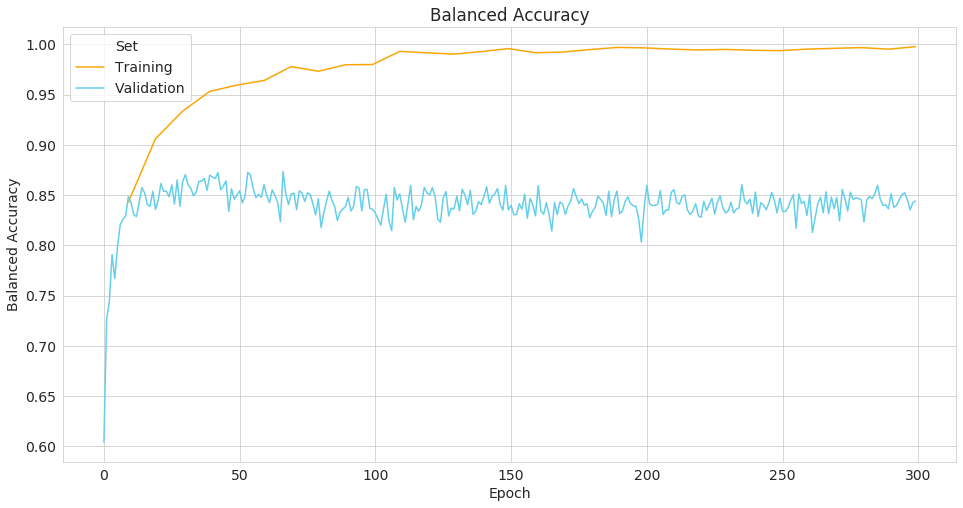

In [45]:
plt.figure(figsize=(16,8))

curves_tags = ["-tag-balanced_accuracy_train", "-tag-balanced_accuracy_val"]

csv_files_loss = list()
for ct in curves_tags:
    csv_files_loss.append(os.path.join("..", "results", "{}{}.csv".format(BEST_EXPERIMENT_NAME, ct)))

plot_tf_log(csv_files_loss, "Balanced Accuracy", y_label="Balanced Accuracy", palette=custom_palette)

In [46]:
bal_acc_val_df = pd.read_csv(os.path.join(
    "..", "results", "{}{}.csv".format(
        BEST_EXPERIMENT_NAME, "-tag-balanced_accuracy_val")))
bal_acc_val_df.iloc[-50:].describe()['Value']

count    50.000000
mean      0.841767
std       0.009792
min       0.812785
25%       0.836387
50%       0.844682
75%       0.847874
max       0.859766
Name: Value, dtype: float64

The results obtained, albeit being biased since estimated on the same validation set used for choosing hyperparameters as explained earlier in the report, seem to be overall comparable with the ones reported by the best models submitted for the ISIC Challenge 2018, task 3 (lesions diagnosis), available at https://challenge2018.isic-archive.com/leaderboards/.
The best model *not* using additional external data for training reports a balanced accuracy score of 0.845, similar to the one reported above (0.842).

However (this is the last time I stress on this, I swear), it is not a fair comparison as my results might perform worse (although I don't expect them to perform *awfully* worse) on the actual test set used for assessing the models submitted for that competition.

### Other metrics

The following are the plots showing values for the **ROC AUC** metric for all seven classes individually.

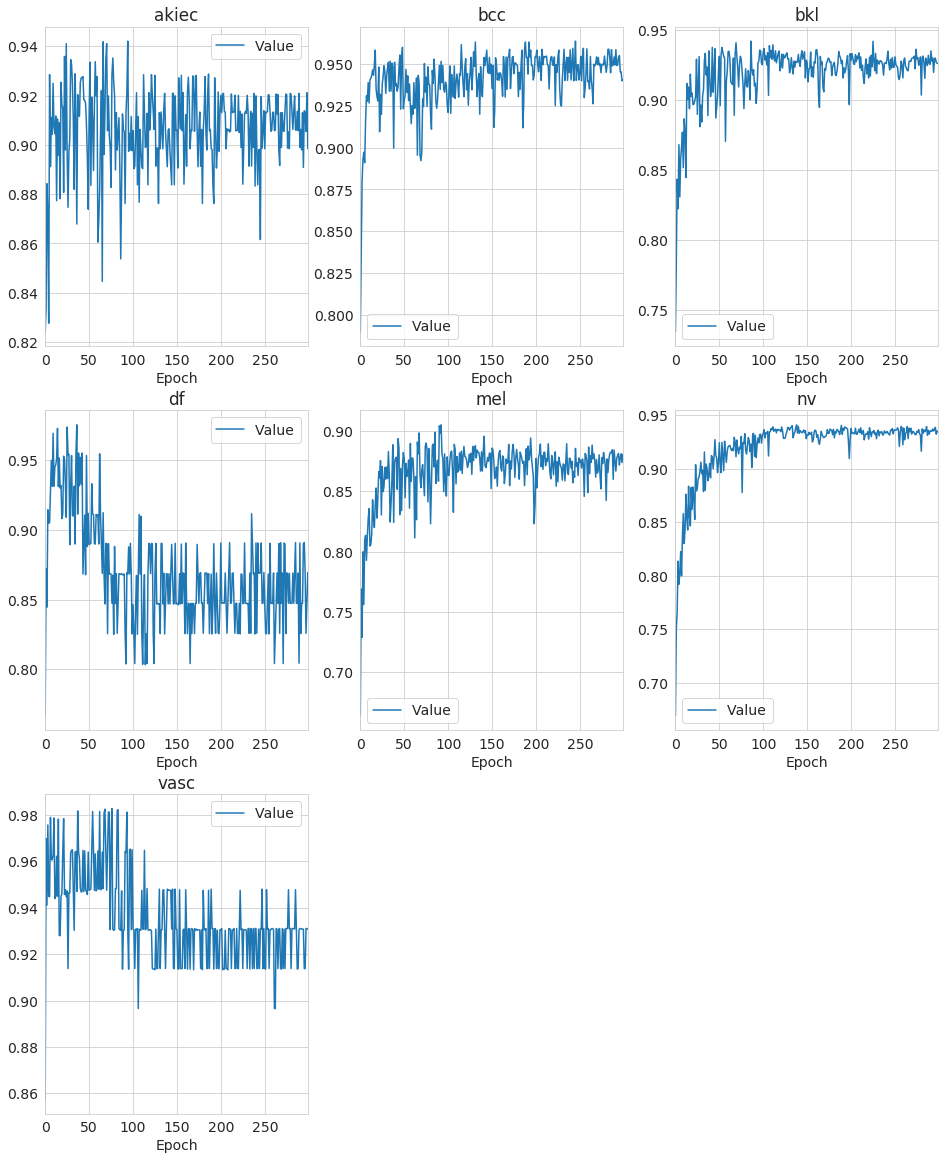

In [47]:
n_rows = 3
n_cols = 3

roc_auc_scores = list()

for c in dataset_train.class_map_dict:
    roc_auc_scores.append({
        'class': c,
        'filename': os.path.join(
            "..", 
            "results", "{}-tag-{}_roc_auc_score_val.csv".format(BEST_EXPERIMENT_NAME, c))
    })
    
f, axes = plt.subplots(n_rows, n_cols, figsize=(16, 20))

for i, d in enumerate(roc_auc_scores):

    x = i//n_rows
    y = i%n_cols
    
    roc_auc_df = pd.read_csv(d['filename'])
    
    roc_auc_df.plot(
        title=d['class'], kind='line', x='Step', y='Value', ax=axes[x, y])
    
    axes[x, y].set_xlabel("Epoch")
    
axes[2, 1].axis('off')
axes[2, 2].axis('off');

As expected, the best results are obtained for the most represented class, `nv`, whereas class `df`, the *least* represented one, achieves the worst results.

The `vasc` class, despite having a similar number of examples with respect to `df` class, achieves significantly better results; this might be due to the fact that those samples appear to be more easily distinguishable even for someone without experience, and thus the algorithm might require less examples to properly learn how to distinguish it from the others.

### Technical details

Experiments have been performed on a PC with the following specs:

 * **CPU**: Intel(R) Core(TM) i7-9700K CPU @ 3.60GHz
 * **RAM**: 32 GB
 * **OS**: Ubuntu 18.04
 * **GPU**: NVIDIA RTX 2080 TI GPU, 11 GB GDDR6 RAM
 * **Nvidia Drivers version**: 430.26
 * **CUDA version**: 10.2
 * **cuDNN version**: 7.6.3.30
 * **Python version**: `Python 3.6.9 | Anaconda, Inc. | (default, Jul 30 2019, 19:07:31)`
 * **PyTorch version**: 1.2.0
 
Each "epoch" (considering both training and the forward pass on the whole validation set) took on average 1:24, for a total elapsed time of 7:03:44 for all 300 epochs.

## Conclusions
[back to top](#Summary)

The series of experiments presented in this report (and those which led to them) resulted in a model able to predict the category of a skin lesion with relatively high accuracy (estimated **91.66 % accuracy**, **84.18 % balanced accuracy**), and the code was written in a way that should facilitate reusability on a different dataset, with minor changes.

This report should contain all the information required to anyone who would like to replicate the results presented.

### Future work

Here is a list of possible modifications to the analysis pipeline which might improve the model's performance:

* Use additional external data from other datasets to compensate for the lack of samples for some of the classes.
* It might be interesting to visualize filters in the early/mid layers of the network and see if/how much they differ from the ones trained on the Imagenet dataset. I would particularly interested in looking at the ones roughly in the beginning/middle, as they should be the ones activating in presence of particular texture patterns, which I assume is quite important for this specific task.
* Consider using more sophistitcated network architectures, such as a different version of the `resnet` with more layers or ona variant of the Inception network, or possibly an ensemble method which uses multiple trained network and a majority vote system to predict the class of a samples.
* In the analysis of biomedical data, apart from obtaining good results in terms of performance, it is also required that those results are somewhat **interpretable**. A step in this direction might be using a technique such as the ones described in this paper: https://arxiv.org/abs/1610.02391. This technique shows visually with a heatmap in which parts of the input the network focuses to make a decision; this might prove helpful in particular to analyze mislabeled samples and understand what was the cause of the error in order to further improve the model.
* Some of the images were taken from areas of the body with quite a lot of hair, it might make sense to preprocess those using a hair removal algorithm such as the one described in this work: https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1600-0846.2011.00603.x. This preprocessing step has been used by some of the submissions to the ISIC Challenge 2018.